In [3]:
import gym
import numpy as np
import cma
import math
import random
import matplotlib.pyplot as plt
import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from numpy import linalg as LA
#Trés optionnel
import networkx as nx
from IPython.display import Image, display


# Robotique : Gym
Dans cette partie nous allons utiliser gym, une librairie permettant de manipuler des environnements physiques facilement en vue d'expérimenter des algorithmes permettant d'apprendre efficacement des politiques.

In [2]:
env = gym.make('CartPole-v1')
observation = env.reset()
total_reward = 0
for t in range(100):
    action = np.random.rand(1,)
    if action > 0:
        action = 1
    else:
        action = 0
    observation, reward, done, info = env.step(action)
    print(observation)
    total_reward += reward
    if done:
        print("Episode finished after %d timesteps" % (t + 1))
        break

[-0.02883217  0.14881798  0.03399974 -0.24350969]
[-0.02585581  0.34343821  0.02912954 -0.52527733]
[-0.01898705  0.53813839  0.018624   -0.80864083]
[-0.00822428  0.73300024  0.00245118 -1.09540778]
[ 0.00643573  0.92808983 -0.01945697 -1.38732062]
[ 0.02499752  1.1234488  -0.04720339 -1.68602362]
[ 0.0474665   1.31908398 -0.08092386 -1.99302216]
[ 0.07384818  1.51495453 -0.1207843  -2.30963214]
[ 0.10414727  1.71095663 -0.16697695 -2.63691761]
[ 0.1383664   1.90690548 -0.2197153  -2.97561634]
Episode finished after 10 timesteps


/home/mohamed/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


On voit bien qu'avec une politique aléatoire le cart tiens seulement 9 timesteps a l'écran.
Dans ce qui suit nous allons entrainer un controller afin de controller le carte et de le faire rester le plus longtemps possible a l'écran.
La structure du controller serra évidente : 
- Etant donné que l'observation se compose de 4 données (position, velocity, angle, velocity du cable) le réseau de neurones prendra ces 4 paramètres en entrée
- La sortie serra tanh et ferra dépendre l'action a prendre
- La fonction d'évaluation serra simplement le reward total cumulé.

In [4]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def gen_simplemlp(n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5):
    n_neurons = [n_neurons_per_hidden]*n_hidden_layers if np.isscalar(n_neurons_per_hidden) else n_neurons_per_hidden
    i = Input(shape=(n_in,))
    x = i
    for n in n_neurons:
        x = Dense(n, activation='sigmoid')(x)
    o = Dense(n_out, activation='tanh')(x)
    m = Model(inputs=i, outputs=o)
    return m
    

class SimpleNeuralControllerNumpy():
    def __init__(self, n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5, params=None):
        self.dim_in = n_in
        self.dim_out = n_out
        # if params is provided, we look for the number of hidden layers and neuron per layer into that parameter (a dicttionary)
        if (not params==None):
            if ("n_hidden_layers" in params.keys()):
                n_hidden_layers=params["n_hidden_layers"]
            if ("n_neurons_per_hidden" in params.keys()):
                n_neurons_per_hidden=params["n_neurons_per_hidden"]
        self.n_per_hidden = n_neurons_per_hidden
        self.n_hidden_layers = n_hidden_layers
        self.weights = None 
        self.n_weights = None
        self.init_random_params()
        self.out = np.zeros(n_out)
        #print("Creating a simple mlp with %d inputs, %d outputs, %d hidden layers and %d neurons per layer"%(n_in, n_out,n_hidden_layers, n_neurons_per_hidden))

    
    def init_random_params(self):
        if(self.n_hidden_layers > 0):
            self.weights = [np.random.random((self.dim_in,self.n_per_hidden))] # In -> first hidden
            self.bias = [np.random.random(self.n_per_hidden)] # In -> first hidden
            for i in range(self.n_hidden_layers-1): # Hidden -> hidden
                self.weights.append(np.random.random((self.n_per_hidden,self.n_per_hidden)))
                self.bias.append(np.random.random(self.n_per_hidden))
            self.weights.append(np.random.random((self.n_per_hidden,self.dim_out))) # -> last hidden -> out
            self.bias.append(np.random.random(self.dim_out))
        else:
            self.weights = [np.random.random((self.dim_in,self.dim_out))] # Single-layer perceptron
            self.bias = [np.random.random(self.dim_out)]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def get_parameters(self):
        """
        Returns all network parameters as a single array
        """
        flat_weights = np.hstack([arr.flatten() for arr in (self.weights+self.bias)])
        return flat_weights

    def set_parameters(self, flat_parameters):
        """
        Set all network parameters from a single array
        """
        i = 0 # index
        to_set = []
        self.weights = list()
        self.bias = list()
        if(self.n_hidden_layers > 0):
            # In -> first hidden
            w0 = np.array(flat_parameters[i:(i+self.dim_in*self.n_per_hidden)])
            self.weights.append(w0.reshape(self.dim_in,self.n_per_hidden))
            i += self.dim_in*self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                w = np.array(flat_parameters[i:(i+self.n_per_hidden*self.n_per_hidden)])
                self.weights.append(w.reshape((self.n_per_hidden,self.n_per_hidden)))
                i += self.n_per_hidden*self.n_per_hidden
            # -> last hidden -> out
            wN = np.array(flat_parameters[i:(i+self.n_per_hidden*self.dim_out)])
            self.weights.append(wN.reshape((self.n_per_hidden,self.dim_out)))
            i += self.n_per_hidden*self.dim_out
            # Samefor bias now
            # In -> first hidden
            b0 = np.array(flat_parameters[i:(i+self.n_per_hidden)])
            self.bias.append(b0)
            i += self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                b = np.array(flat_parameters[i:(i+self.n_per_hidden)])
                self.bias.append(b)
                i += self.n_per_hidden
            # -> last hidden -> out
            bN = np.array(flat_parameters[i:(i+self.dim_out)])
            self.bias.append(bN)
            i += self.dim_out
        else:
            n_w = self.dim_in*self.dim_out
            w = np.array(flat_parameters[:n_w])
            self.weights = [w.reshape((self.dim_in,self.dim_out))]
            self.bias = [np.array(flat_parameters[n_w:])]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])
    
    def predict(self,x):
        """
        Propagage
        """
        if(self.n_hidden_layers > 0):
            #Input
            a = np.matmul(x,self.weights[0]) + self.bias[0]
            y = sigmoid(a)
            # hidden -> hidden
            for i in range(1,self.n_hidden_layers-1):
                a = np.matmul(y, self.weights[i]) + self.bias[i]
                y = sigmoid(a)
            # Out
            a = np.matmul(y, self.weights[-1]) + self.bias[-1]
            out = tanh(a)
            return out
        else: # Simple monolayer perceptron
            return tanh(np.matmul(x,self.weights[0]) + self.bias[0])

    def __call__(self,x):
        """Calling the controller calls predict"""
        return self.predict(x)


nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)


In [4]:
def eval_nn(genotype, render=True):
    total_reward=0
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    nn.set_parameters(genotype)
    observation = env.reset()
    for t in range(1000):
        if render:
            env.render()
        action=nn.predict(observation)
        if action>0:
            action=1
        else:
            action=0
        observation, reward, done, info = env.step(action)
        total_reward+=reward
        if done:
            print("Episode finished after %d timesteps"%(t+1))
            break
    return -total_reward

In [5]:
import cma.purecma as purecma
nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)
nn.init_random_params()
w = nn.get_parameters()
res = cma.CMAEvolutionStrategy(w, 0.5).optimize(eval_nn,maxfun=10000).result


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 61 (seed=355236, Tue Apr  7 13:48:42 2020)
Episode finished after 11 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 20 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.000000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.3
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished a

Episode finished after 159 timesteps
Episode finished after 31 timesteps
Episode finished after 15 timesteps
Episode finished after 17 timesteps
Episode finished after 9 timesteps
Episode finished after 22 timesteps
Episode finished after 50 timesteps
Episode finished after 53 timesteps
Episode finished after 37 timesteps
Episode finished after 14 timesteps
Episode finished after 10 timesteps
Episode finished after 39 timesteps
Episode finished after 12 timesteps
Episode finished after 30 timesteps
Episode finished after 24 timesteps
Episode finished after 59 timesteps
Episode finished after 54 timesteps
Episode finished after 20 timesteps
Episode finished after 17 timesteps
Episode finished after 18 timesteps
Episode finished after 20 timesteps
Episode finished after 17 timesteps
Episode finished after 81 timesteps
Episode finished after 62 timesteps
Episode finished after 428 timesteps
Episode finished after 9 timesteps
Episode finished after 18 timesteps
Episode finished after 137 t

Episode finished after 25 timesteps
Episode finished after 10 timesteps
Episode finished after 28 timesteps
Episode finished after 52 timesteps
Episode finished after 95 timesteps
Episode finished after 30 timesteps
Episode finished after 52 timesteps
Episode finished after 30 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 43 timesteps
Episode finished after 42 timesteps
Episode finished after 39 timesteps
Episode finished after 28 timesteps
Episode finished after 51 timesteps
Episode finished after 65 timesteps
Episode finished after 42 timesteps
Episode finished after 55 timesteps
Episode finished after 64 timesteps
Episode finished after 185 timesteps
Episode finished after 9 timesteps
Episode finished after 28 timesteps
Episode finished after 34 timesteps
Episode finished after 33 timesteps
Episode finished after 51 timesteps
Episode finished after 150 timesteps
Episode finished after 17 timesteps
Episode finished after 95 tim

Episode finished after 101 timesteps
Episode finished after 235 timesteps
Episode finished after 16 timesteps
Episode finished after 57 timesteps
Episode finished after 74 timesteps
Episode finished after 329 timesteps
Episode finished after 35 timesteps
Episode finished after 57 timesteps
Episode finished after 74 timesteps
Episode finished after 53 timesteps
Episode finished after 87 timesteps
Episode finished after 31 timesteps
Episode finished after 48 timesteps
Episode finished after 78 timesteps
Episode finished after 166 timesteps
Episode finished after 33 timesteps
Episode finished after 146 timesteps
Episode finished after 52 timesteps
Episode finished after 55 timesteps
Episode finished after 82 timesteps
Episode finished after 34 timesteps
Episode finished after 258 timesteps
Episode finished after 45 timesteps
Episode finished after 41 timesteps
Episode finished after 36 timesteps
Episode finished after 73 timesteps
Episode finished after 40 timesteps
Episode finished after

Episode finished after 46 timesteps
Episode finished after 28 timesteps
Episode finished after 56 timesteps
Episode finished after 36 timesteps
Episode finished after 54 timesteps
Episode finished after 45 timesteps
Episode finished after 78 timesteps
Episode finished after 39 timesteps
Episode finished after 45 timesteps
Episode finished after 35 timesteps
Episode finished after 25 timesteps
Episode finished after 46 timesteps
Episode finished after 43 timesteps
Episode finished after 28 timesteps
Episode finished after 17 timesteps
Episode finished after 39 timesteps
Episode finished after 40 timesteps
Episode finished after 33 timesteps
Episode finished after 118 timesteps
Episode finished after 176 timesteps
Episode finished after 28 timesteps
Episode finished after 39 timesteps
Episode finished after 58 timesteps
Episode finished after 61 timesteps
Episode finished after 30 timesteps
Episode finished after 63 timesteps
Episode finished after 30 timesteps
Episode finished after 28 

Episode finished after 151 timesteps
Episode finished after 57 timesteps
Episode finished after 63 timesteps
Episode finished after 66 timesteps
Episode finished after 54 timesteps
Episode finished after 125 timesteps
Episode finished after 70 timesteps
Episode finished after 40 timesteps
Episode finished after 91 timesteps
Episode finished after 324 timesteps
Episode finished after 56 timesteps
Episode finished after 450 timesteps
Episode finished after 51 timesteps
Episode finished after 63 timesteps
Episode finished after 65 timesteps
Episode finished after 58 timesteps
Episode finished after 27 timesteps
Episode finished after 47 timesteps
Episode finished after 151 timesteps
Episode finished after 56 timesteps
Episode finished after 59 timesteps
Episode finished after 74 timesteps
Episode finished after 31 timesteps
Episode finished after 39 timesteps
Episode finished after 45 timesteps
Episode finished after 60 timesteps
Episode finished after 34 timesteps
Episode finished after 

KeyboardInterrupt: 

# Programmation Génétique :

In [6]:
import math
import random

import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [7]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [8]:



creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def f(x):
    d = x**4 - x**3 + x**2 + np.sin(2*x+3)
    return d

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - f(x))**2 for x in points)
    return math.fsum(sqerrors) / len(points),



toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))




pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
    
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 172, stats=mstats,halloffame=hof, verbose=True)


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	6.32352	0  	1063.08	0.413369	300   	61.1599	3.57667	0  	7  	2  	300   	1.42506
1  	186   	2.253  	1  	23.914 	0.607941	186   	2.24577	3.47667	1  	8  	1  	186   	1.39145
2  	161   	1.86741	2  	21.5477	0.607941	161   	2.14403	3.84   	2  	10 	1  	161   	1.64957
3  	160   	1.87454	3  	89.9224	0.284917	160   	5.24116	4.14667	3  	11 	1  	160   	1.7847 
4  	165   	1.91028	4  	127.339	0.164494	165   	7.36842	4.75   	4  	11 	1  	165   	1.9011 
5  	155   	1.26248	5  	5.10444	0.1141  	155   	1.08018	5.30667	5  	14 	1  	155   	2.05247
6  	162   	1.2498 	6  	23.9499	0.164494	162   	2.07744	5.57333	6  	17 	1  	162   	2.14584
7  	163   	1.42463	7  	23.9499	0.1141  	163   	2.3

88 	169   	104.515 	88 	27964.8	0.0123111	169   	1614.73	14.9367	88 	42 	1  	169   	7.05875
89 	162   	6.75804 	89 	1290.69	0.0123111	162   	76.3431	15.88  	89 	46 	1  	162   	7.75192
90 	159   	1.70161 	90 	70.0165	0.0123111	159   	5.86684	17.0633	90 	46 	1  	159   	8.05767
91 	153   	840.183 	91 	251768 	0.0123111	153   	14511.5	17.1533	91 	43 	4  	153   	8.21603
92 	171   	1.90608 	92 	139.724	0.0123111	171   	10.0184	17.94  	92 	45 	1  	171   	8.66736
93 	193   	4.53869 	93 	530.887	0.0123111	193   	36.8323	18.8633	93 	46 	3  	193   	8.88546
94 	166   	5.09178 	94 	1132.03	0.0123111	166   	65.566 	20.0433	94 	45 	6  	166   	8.71176
95 	149   	5.50699 	95 	869.325	0.0123111	149   	54.959 	19.9833	95 	45 	3  	149   	8.42198
96 	155   	1.19258 	96 	67.9105	0.0123111	155   	4.97856	20.2633	96 	46 	3  	155   	8.89873
97 	159   	4.76605 	97 	1077.57	0.0123111	159   	63.0839	21.1367	97 	51 	3  	159   	9.09091
98 	167   	934.401 	98 	279731 	0.0123111	167   	16123.2	21.8633	98 	51 	1  	167

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (2, 6), (6, 7), (6, 8), (1, 9), (0, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (18, 20), (20, 21), (21, 22), (22, 23), (22, 24), (24, 25), (24, 26), (26, 27), (26, 28), (21, 29), (20, 30), (30, 31), (30, 32), (17, 33), (33, 34), (34, 35), (35, 36), (35, 37), (37, 38), (37, 39), (34, 40), (40, 41), (40, 42), (42, 43), (43, 44), (43, 45), (42, 46), (16, 47), (15, 48), (48, 49), (49, 50), (49, 51), (51, 52), (52, 53), (53, 54), (54, 55), (54, 56), (53, 57), (57, 58), (51, 59), (13, 60), (12, 61), (61, 62), (62, 63), (63, 64), (63, 65), (65, 66), (66

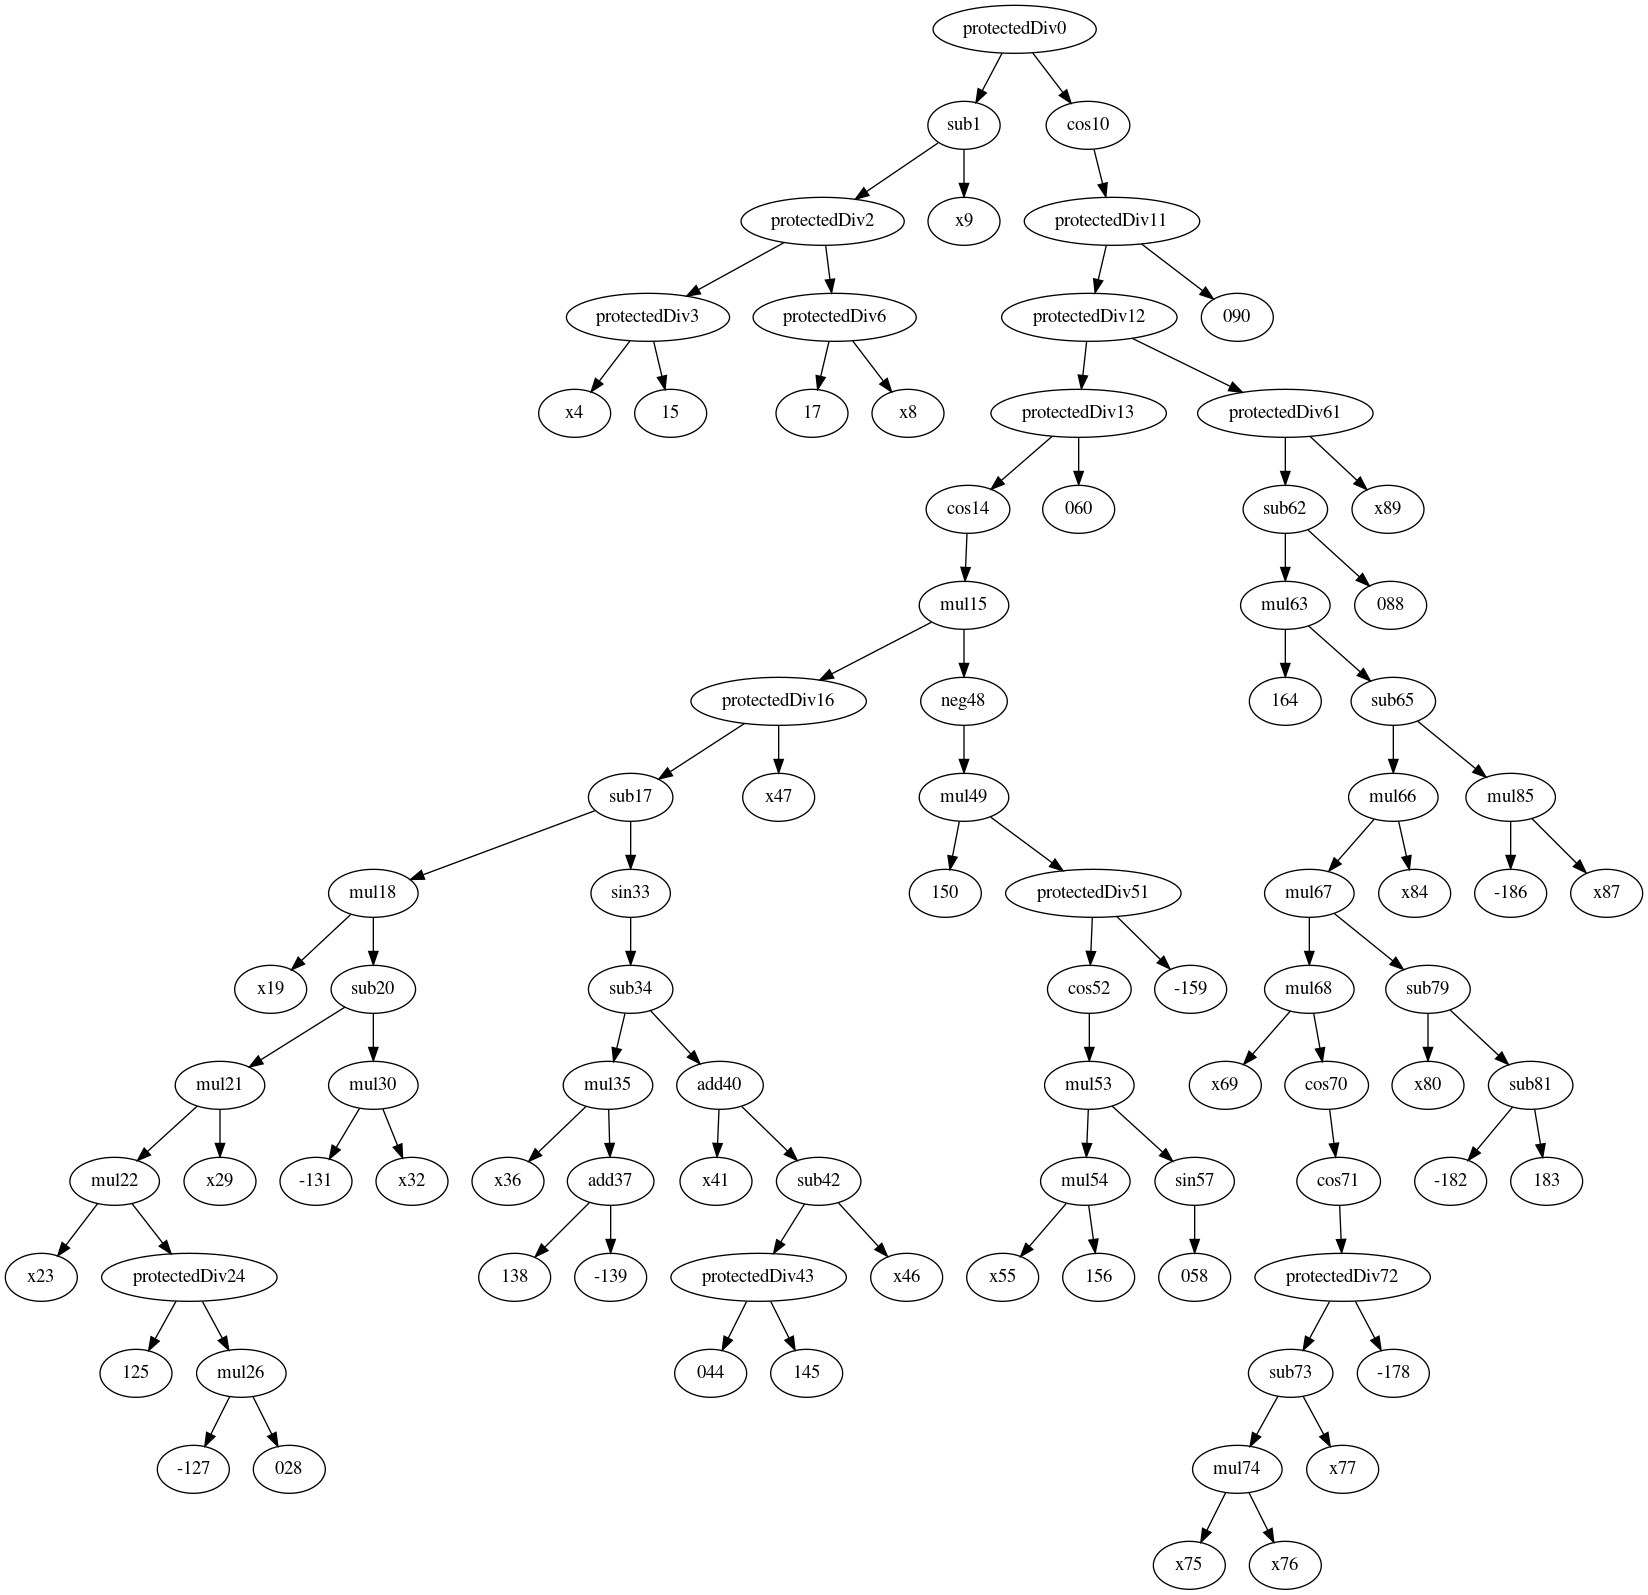

In [9]:
nodes, edges, labels = gp.graph(hof[0])

print(nodes)
print(edges)
print(labels)
sommets = []
arcs = [(str(labels[i])+str(i),str(labels[j])+str(j)) for i,j in edges]
for i,j in arcs:
    if not i in sommets:
        sommets.append(i)
    if not j in sommets:
        sommets.append(j)

G = nx.MultiDiGraph()
G.add_nodes_from(sommets )
G.add_edges_from(arcs)

#for i in nodes:
#    n = G.get_node(i)
#    n.attr["label"] = labels[i]
#

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(G)
view_pydot(pdot)

In [1]:
import gym
import numpy as np
import cma
import math
import random
import matplotlib.pyplot as plt
import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from numpy import linalg as LA
#Trés optionnel
import networkx as nx
from IPython.display import Image, display


x = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

def adapt(X):
    return np.hstack((X,np.ones((X.shape[0],1))))  

def predictions(w,x):
    ypredict = np.dot(x,w.T)
    return ypredict

w = np.dot(np.linalg.pinv(adapt(x)),y)
print("Donc le modèle qu'on trouve est : ",w.T)

plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,adapt(x))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

Donc le modèle qu'on trouve est :  [[ 0.34163559 -0.00502028]]


<Figure size 640x480 with 1 Axes>

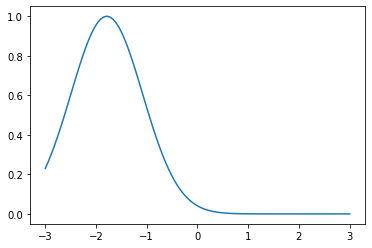

b1 =  (100, 1)
x =  (100, 1)
Donc le modèle qu'on trouve est :  [[-1.26617224 -0.03553026  1.0925261 ]]


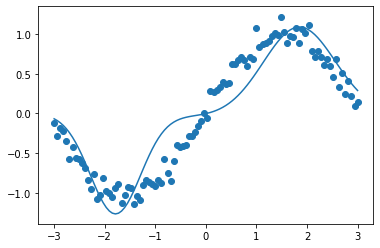

In [2]:
def radial_basis_func(X,center=0.5,widths=1):
    c = X[int(center*X.shape[0])]
    return np.exp(-np.divide(np.square(x - c), widths))

recepient = [(0.2,0.5),(0.5,1),(0.8,1)]

def kernel(X,recipients):
    H = radial_basis_func(X,center = recipients[0][0],widths=recipients[0][1])
    for r in recipients[1:]:
        H = np.hstack((H,radial_basis_func(X,center = r[0],widths=r[1])))
    return H

def display_recipients(X,reciepients):
    for r in reciepients:
        y = radial_basis_func(X,center = r[0],widths=r[1])
        plt.plot(X,y)
    plt.show()

b1 = radial_basis_func(x,center = 0.2)
plt.plot(x,b1)
plt.show()
print("b1 = ",b1.shape)
print("x = ",x.shape)


w = np.dot(np.linalg.pinv(kernel(x,recepient).T.dot(kernel(x,recepient))),kernel(x,recepient).T.dot(y))


print("Donc le modèle qu'on trouve est : ",w.T)
plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,kernel(x,recepient))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

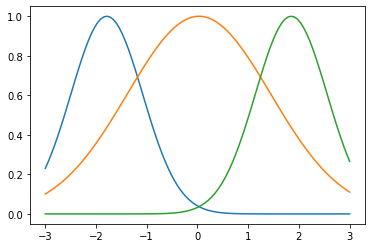

Donc le modèle qu'on trouve est :  [[-1.11151449  0.02198825  1.09455974]]


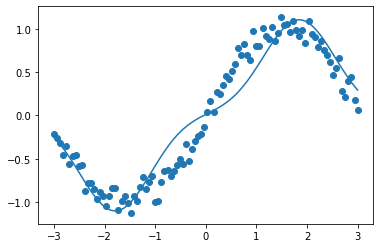

In [3]:
x = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

recepient = [(0.2,1),(0.5,4),(0.8,1)]
display_recipients(x,recepient)

w = np.dot(np.linalg.pinv(kernel(x,recepient).T.dot(kernel(x,recepient))),kernel(x,recepient).T.dot(y))


print("Donc le modèle qu'on trouve est : ",w.T)
plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,kernel(x,recepient))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

In [4]:
def kernel(X,recipients):
    H = radial_basis_func(X,center = recipients[0][0],widths=recipients[0][1])
    for r in recipients[1:]:
        H = np.hstack((H,radial_basis_func(X,center = r[0],widths=r[1])))
    return H

def adding_kernel(X,rec):
    H = np.hstack((X,radial_basis_func(X,center = rec[0],widths=rec[1])))
    return H

def identity(x):
    return x

def recipien_generator():
    return tuple([np.random.rand(1)[0],np.random.uniform(1,10)])

pset2 = gp.PrimitiveSetTyped("KERN_MAIN", [np.ndarray],np.ndarray)
pset2.addPrimitive(adding_kernel, [np.ndarray, tuple], np.ndarray)
pset2.addPrimitive(identity, [tuple], tuple)

pset2.addEphemeralConstant("recipient2",recipien_generator , tuple)

pset2.renameArguments(ARG0='x')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset2, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset2)

In [6]:
from sklearn.metrics import mean_squared_error

X = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

def eval_kernel(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    K = func(X)
    try:
        w = np.dot(np.linalg.pinv(K.T.dot(K)),K.T.dot(y))
        ypred = predictions(w.T,K)
        fitness = mean_squared_error(y,ypred)
    except(np.linalg.LinAlgError):
        fitness = 1e20
    return fitness,



toolbox.register("evaluate", eval_kernel)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset2)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))




In [8]:
pop = toolbox.population(n=2)
hof = tools.HallOfFame(1)
    
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

pop,log= algorithms.eaMuPlusLambda(pop, toolbox, mu=20, lambda_=100, cxpb=0, mutpb=0.3, ngen=200, stats=mstats,halloffame=hof, verbose=True)


   	      	                                 fitness                                 
   	      	-------------------------------------------------------------------------
gen	nevals	avg      	gen	max     	min       	nevals	std      
0  	2     	0.0903954	0  	0.172068	0.00872243	2     	0.0816729
1  	31    	0.0169117	1  	0.172068	0.00869921	31    	0.0355955
2  	41    	0.00871764	2  	0.00874035	0.00868665	41    	1.38334e-05
3  	32    	0.00867268	3  	0.00872243	0.00842391	32    	8.01039e-05
4  	28    	0.00855042	4  	0.00872243	0.00806219	28    	0.000160707
5  	28    	0.00840698	5  	0.00868665	0.00806219	28    	0.000192491
6  	26    	0.00827035	6  	0.00868665	0.00806219	26    	0.000204519
7  	31    	0.00805751	7  	0.00806219	0.00803766	31    	8.6678e-06 
8  	28    	0.00805048	8  	0.00806219	0.00803766	28    	1.02531e-05
9  	30    	0.00804426	9  	0.00806219	0.00803766	30    	8.70442e-06
10 	29    	0.00803778	10 	0.00806219	0.00800742	29    	9.14754e-06
11 	33    	0.00802592	11 	0.00804142	0.00

121	31    	0.00761948	121	0.00761948	0.00761948	31    	8.67362e-19
122	26    	0.00761948	122	0.00761948	0.00761948	26    	8.67362e-19
123	24    	0.00761948	123	0.00761948	0.00761948	24    	8.67362e-19
124	34    	0.00761948	124	0.00761948	0.00761948	34    	8.67362e-19
125	32    	0.00761948	125	0.00761948	0.00761948	32    	8.67362e-19
126	28    	0.00761948	126	0.00761948	0.00761948	28    	8.67362e-19
127	29    	0.0076193 	127	0.00761948	0.00761767	29    	5.41738e-07
128	31    	0.00761903	128	0.00761948	0.00761767	31    	7.81932e-07
129	29    	0.00761902	129	0.00762664	0.00761767	29    	1.95651e-06
130	34    	0.00761794	130	0.00761948	0.00761767	34    	6.44798e-07
131	25    	0.00761767	131	0.00761767	0.00761767	25    	8.67362e-19
132	27    	0.00762157	132	0.0076957 	0.00761767	27    	1.70052e-05
133	44    	0.00762546	133	0.00775442	0.00761767	44    	2.96742e-05
134	32    	0.00761776	134	0.00762492	0.0076148 	32    	1.79333e-06
135	25    	0.00761736	135	0.00762492	0.00761418	25    	2.11486

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (6, 8), (5, 9), (9, 10), (10, 11), (4, 12), (12, 13), (13, 14), (3, 15), (15, 16), (2, 17), (17, 18), (18, 19), (1, 20), (20, 21), (0, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27)]
{0: 'adding_kernel', 1: 'adding_kernel', 2: 'adding_kernel', 3: 'adding_kernel', 4: 'adding_kernel', 5: 'adding_kernel', 6: 'adding_kernel', 7: 'x', 8: (0.1611642554011219, 1.1326922283738665), 9: 'identity', 10: 'identity', 11: (0.3488981461089866, 1.6706592948140604), 12: 'identity', 13: 'identity', 14: (0.006014821200239662, 6.606102059340743), 15: 'identity', 16: (0.06900194389782954, 3.129960207678879), 17: 'identity', 18: 'identity', 19: (0.21813917075261824, 2.1754185102222254), 20: 'identity', 21: (0.07723861929178144, 1.9614645598350853), 22: 'identity', 23: 'identity', 24: 'identity', 25: 'identity', 26: 'identity', 27: (0.873976047

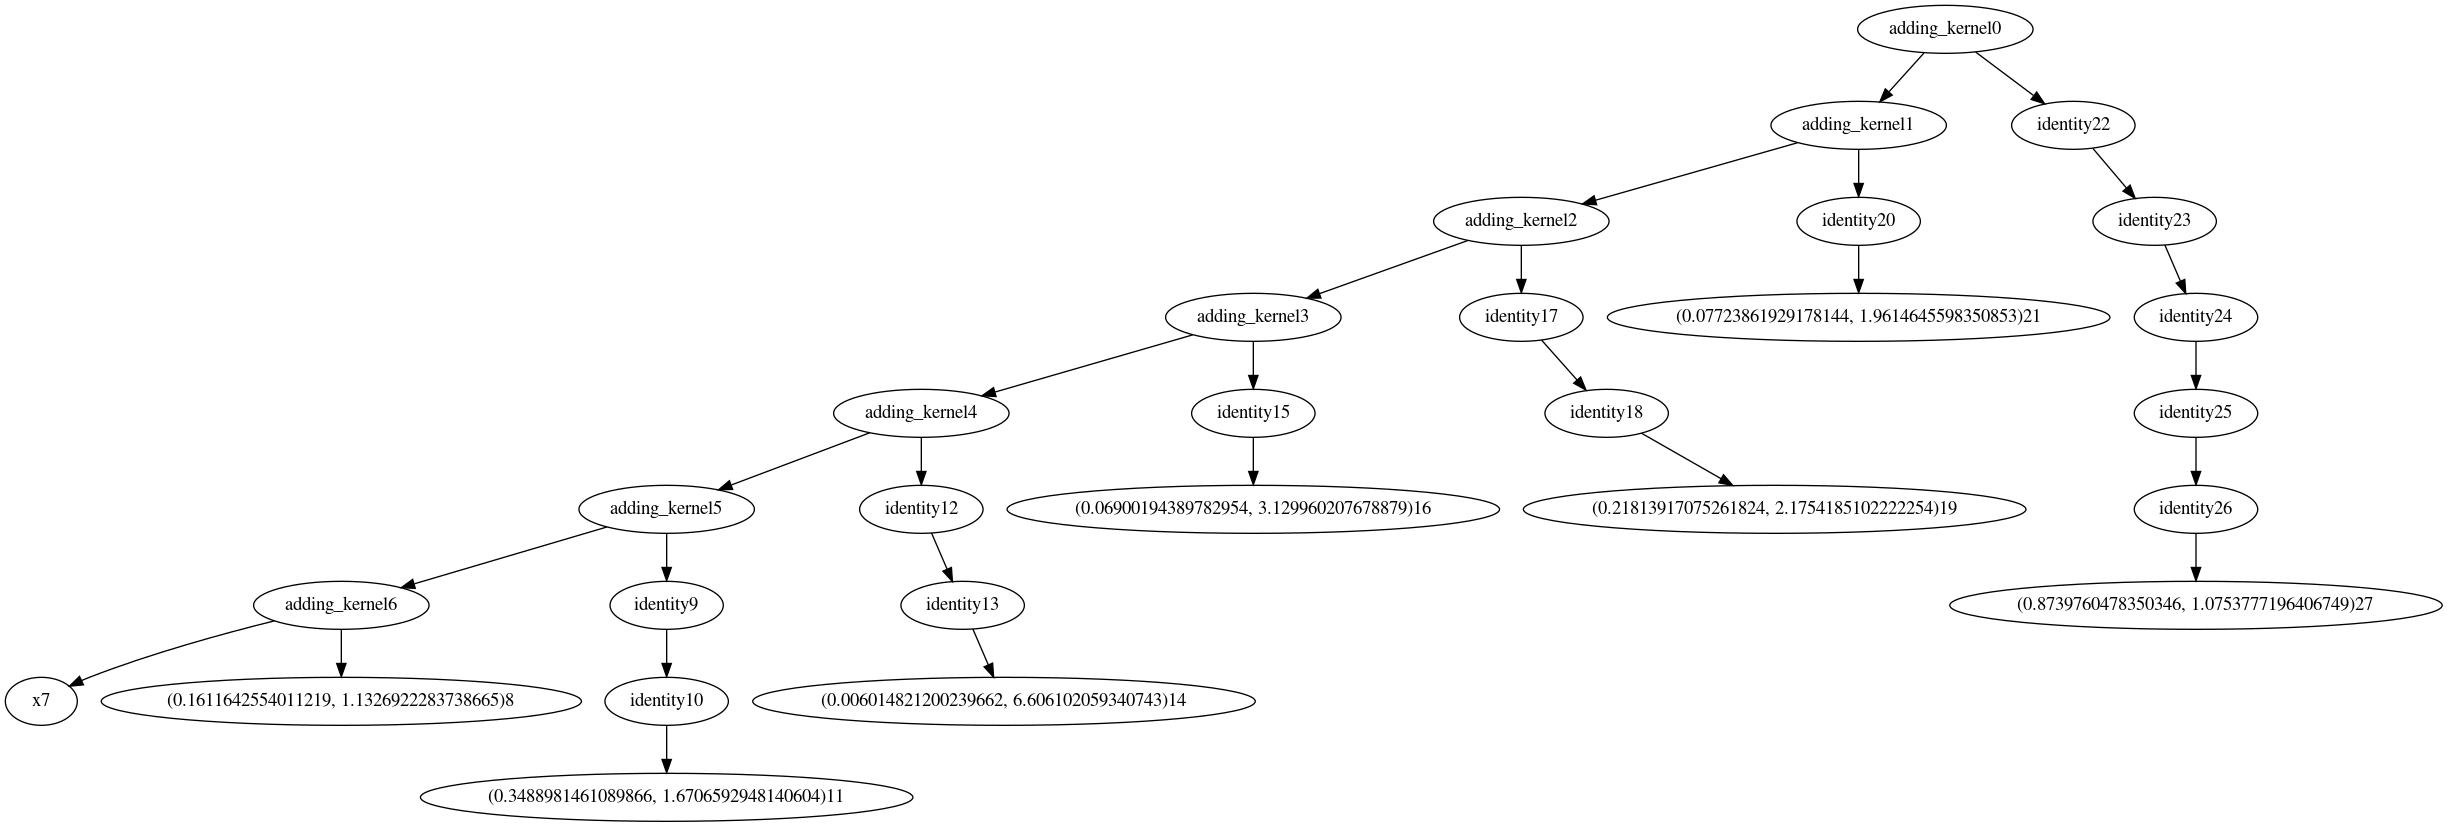

In [9]:
nodes, edges, labels = gp.graph(hof[0])

print(nodes)
print(edges)
print(labels)
sommets = []
arcs = [(str(labels[i])+str(i),str(labels[j])+str(j)) for i,j in edges]
for i,j in arcs:
    if not i in sommets:
        sommets.append(i)
    if not j in sommets:
        sommets.append(j)

G = nx.MultiDiGraph()
G.add_nodes_from(sommets )
G.add_edges_from(arcs)

#for i in nodes:
#    n = G.get_node(i)
#    n.attr["label"] = labels[i]
#

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(G)
view_pydot(pdot)

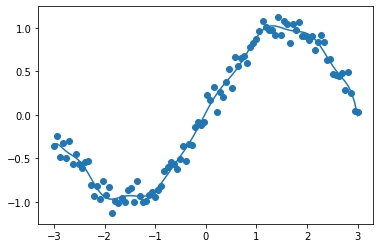

In [10]:
func = toolbox.compile(expr=hof[0])
K = func(X)
w = np.dot(np.linalg.pinv(K.T.dot(K)),K.T.dot(y))
#Calcul des prédictions
ypred = predictions(w.T,K)
plt.scatter(X,y)
#Tracage du modèle : 
plt.plot(X,ypred)
plt.show()

# Résolution d'un problème SAT 

In [112]:
from pysat.formula import CNF
import numpy as np


formula = CNF(from_file='input1.cnf')
clause = formula.clauses
L = []
for c in clause:
    L.append(np.array(c))
L = np.array(L)
print(L)

def transform(clause):
    L = []
    for c in clause:
        L.append(np.array(c))
    L = np.array(L)
    return L



def nb_sat(valuation):
    n = 0
    valuation = np.array(valuation)
    for clause in L:
        if(len(clause)!=0):
            a = valuation[clause]
            for c,cl in zip(a,clause):
                if(c == 1 and cl>0):
                    n = n + 1
                    break
                if(c == 0 and cl<0):
                    n = n + 1
                    break
    return n,

def count_clauses():
    n = 0
    for clause in L:
        if(len(clause)!=0):
            n = n + 1
    return n


nb_sat(np.array((formula.nv+1)*[1]))
print(count_clauses())

[array([ 40, -50,  57]) array([ 45,   7, -39]) array([ 24, -42,  26])
 array([25, 29, 56]) array([-16, -28,  35]) array([40,  9, 64])
 array([54, 67, 43]) array([-14, -33, -42]) array([48,  1, 70])
 array([-36,  27,  56]) array([ -8, -53, -33]) array([-32, -52, -47])
 array([ -1,  -7, -14]) array([  9, -18,  65]) array([ 31,  -6, -27])
 array([-35,   8,  17]) array([ 48,  36, -67]) array([ 1, 36, 66])
 array([-3, 11, 54]) array([ 68, -44,  29]) array([-58,  15, -36])
 array([ 14, -56,  75]) array([-65,   1, -71]) array([17, 10, 70])
 array([  1, -68, -46]) array([  3, -62, -35]) array([ 16, -49,  74])
 array([-11, -49,  31]) array([  8,   4, -39]) array([-20,  13,  54])
 array([64, 34, 12]) array([ 22, -52,  54]) array([55, -8, -1])
 array([39,  7, 67]) array([-64,  29, -16]) array([68,  8, -6])
 array([ -9, -53,  18]) array([ 14, -53,  23]) array([-2, 26, 28])
 array([ 71, -16,  66]) array([-58, -50, -17]) array([-29, -62,  25])
 array([61, 62, -1]) array([-29,  -2, -14]) array([ 18, 

In [179]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, formula.nv+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", nb_sat)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=6)

pop = toolbox.population(n=100)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
l=algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=1000,stats=stats)
#l= algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.4, mutpb=0.3, ngen=1000, stats=stats)

/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg   	std    	min	max
0  	100   	285.34	6.00536	272	300
1  	59    	291.62	4.675  	279	300
2  	69    	295.84	3.62138	283	304
3  	64    	297.75	3.79045	286	304
4  	54    	300.19	3.37252	286	305
5  	53    	302.11	2.98963	292	306
6  	64    	303.42	2.40075	296	309
7  	58    	304.4 	2.99666	291	310
8  	68    	305.87	3.04518	296	310
9  	64    	306.58	3.57821	290	310
10 	72    	306.67	3.27125	294	311
11 	54    	307.57	3.05043	299	311
12 	66    	307.97	3.348  	297	311
13 	72    	308.96	3.30127	298	313
14 	57    	310.22	2.04734	303	313
15 	68    	310.44	2.32946	302	314
16 	73    	311.57	2.43826	302	314
17 	66    	312   	2.24499	304	315
18 	67    	312.71	2.22394	305	315
19 	56    	313.52	2.11414	303	315
20 	57    	313.64	2.67028	302	315
21 	68    	313.5 	3.52846	297	315
22 	61    	313.63	2.99217	301	316
23 	63    	314.17	1.95987	306	316
24 	70    	313.51	3.01826	303	316
25 	55    	313.95	3.1285 	301	316
26 	58    	314.26	2.93809	304	316
27 	75    	314.59	2.98361	302	316
28 	53    	314

KeyboardInterrupt: 

# Utilisation d'une évaluation multi-critère


## Introduction a la décision multi-critères 

    x   y
0  10  12
1  15  11
2   8   8
3  17   5
4   6  18
5   8  12
6  12  16
7  10  17
8  12  10


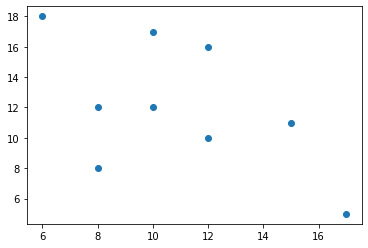

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
datas = [
    dict(
        x = 10,
        y = 12
    ),
    dict(
        x = 15,
        y = 11
    ),
    dict(
        x = 8,
        y = 8
    ),
    dict(
        x = 17,
        y = 5
    ),
    dict(
        x = 6,
        y = 18
    ),
    dict(
        x = 8,
        y = 12
    ),
    dict(
        x = 12,
        y = 16
    ),
    dict(
        x = 10,
        y = 17
    ),
    dict(
        x = 12,
        y = 10
    ),
]
X = [d["x"] for d in datas]
Y = [d["y"] for d in datas]
df = pd.DataFrame(datas)
print(df)
plt.scatter(X,Y)

In [161]:
def calculer_front(X):
    L = X
    for i in X:
        for j in L:
            if(i["x"] >= j["x"] and i["y"] > j["y"] or i["x"] > j["x"] and i["y"] >= j["y"]):
                L.remove(j)
            if(j["x"] >= i["x"] and j["y"] > i["y"] or j["x"] > i["x"] and j["y"] >= i["y"]):
                L.remove(i)
    return L


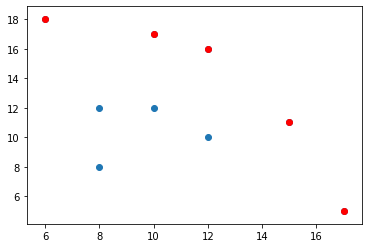

In [162]:
X = [d["x"] for d in datas]
Y = [d["y"] for d in datas]
plt.scatter(X,Y)
calculer_front(datas)
X = [d["x"] for d in datas]
Y = [d["y"] for d in datas]
plt.scatter(X,Y,color = "red")
plt.show()


## Algorithmes evolutionnaires Multi-critères NSGA2 et NSGA3

In [7]:
nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)
nn.init_random_params()
w = nn.get_parameters()

creator.create("MaFitness", base.Fitness, weights=(-1.0,-1.0,+2.0))
creator.create("Individual", list, fitness=creator.MaFitness)

toolbox = base.Toolbox()

# à compléter pour sélectionner les opérateurs de mutation, croisement, sélection avec des toolbox.register(...)

# Attribute generator
toolbox.register("attr_float", random.uniform, -2, 2)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, len(w))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxSimulatedBinary, eta = 0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, indpb=0.05, eta = 15, low = -5, up = 5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Les statistiques permettant de récupérer les résultats
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[2])
stats_size = tools.Statistics(lambda ind: -ind.fitness.values[0])
mstats = tools.MultiStatistics(temps=stats_fit, erreur=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("max", numpy.max)
# La structure qui permet de stocker les statistiques
logbook = tools.Logbook()

# La structure permettant de récupérer le meilleur individu
hof = tools.HallOfFame(1)

## à compléter pour initialiser l'algorithme, n'oubliez pas de mettre à jour les statistiques, le logbook et le hall-of-fame.

pop = toolbox.population(n=100)
CXPB, MUTPB = 0.5, 0.2

hof.update(pop)

/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'MaFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [14]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 500
def eval_nn(genotype, render=True, nbstep=500, doPrint = True):
    global errors
    global position
    observation = env.reset()
    total_reward = 0
    total_x=0 # l'erreur en x est dans observation[0]
    total_theta=0 #  l'erreur en theta est dans obervation[2]
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    nn.set_parameters(genotype)
    maxXerr = 0
    maxThetaerr = 0
    ti = 0
    observation = env.reset()
    for t in range(nbstep):
        ti = t
        if render:
            env.render()
        action = nn.predict(observation)
        if action > 0:
            action = 1
        else:
            action = 0
        observation, reward, done, info = env.step(action)
        total_x += np.abs(observation[0]-0.2)
        total_theta += np.abs(observation[2])
        if(done):
            break
        if maxXerr < np.abs(observation[0]) :
            maxXerr = np.abs(observation[0])
        if maxThetaerr < np.abs(observation[2]) :
            maxThetaerr = np.abs(observation[2])
    return (total_x/t, total_theta/t, t)

toolbox.register("evaluate", eval_nn)
l=algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=1000,stats=mstats,verbose=True,)



   	      	                    erreur                    	            temps             
   	      	----------------------------------------------	------------------------------
gen	nevals	avg      	gen	max       	nevals	avg   	gen	max	nevals
0  	0     	-0.146758	0  	-0.0344705	0     	348.68	0  	499	0     


/home/mohamed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


1  	68    	-1.4621  	1  	-0.0344705	68    	364.62	1  	499	68    
2  	68    	-1.68701 	2  	-0.0344705	68    	364.06	2  	499	68    
3  	61    	-1.65866 	3  	-0.0344705	61    	385.09	3  	499	61    


KeyboardInterrupt: 